## Code inspired by David Sumpter (Soccermatics)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [10]:
parser = Sbopen()
df_match = parser.match(competition_id = 2, season_id = 27) #2015/16 premier league season
#get a team
team = 'Liverpool'
#get a list of matches
get_matchids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
                             
no_games = len(get_matchids)

In [15]:
# List of match IDs to be dropped because I want only Jurgen Klopp numbers (hence removing Brendan Rodgers' 15/16 numbers)
match_ids_to_drop = [3753985, 3754020, 3754129, 3753984, 3754003, 3754040, 3754212, 3754060]

# Filter out the unwanted match IDs
matchids = [match_id for match_id in get_matchids if match_id not in match_ids_to_drop]

# Number of games/match_ids after dropping the specified match IDs
no_games_after_drop = len(filtered_matchids)


In [16]:
print(matchids)
print(no_games_after_drop)

[3754042, 3754055, 3754226, 3754255, 3754047, 3754051, 3754098, 3754143, 3754198, 3754208, 3754230, 3754351, 3754343, 3754064, 3753986, 3753991, 3754018, 3754087, 3754154, 3754214, 3754216, 3754220, 3754251, 3754275, 3754294, 3754305, 3754316, 3754342, 3754345, 3754348]
30


## Finding danger passes

In [43]:
danger_passes = pd.DataFrame()  #empty dataframe
for idx in matchids:
        df = parser.event(idx)[0]  #open event data
        for period in [1,2]:
            #keep only accurate LFC passes that were not set-pieces
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            #keep necessary columns
            passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
            #keep only shots by LFC
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            #keep only necessary columns
            shots = df.loc[mask_shot, ["minute", "second"]]
            #time to seconds
            shot_times = shots ['minute'] * 60 +shots['second']
            shot_window = 15 #since passes 15 seconds before shots are taken for danger
            #find starts of the shot windows
            shot_start  = shot_times - shot_window
            #to avoid negative shot starts
            shot_start = shot_start.apply (lambda i: i if i<0 else (period - 1)*45)
            #convert to seconds
            pass_times = passes ['minute'] *60 +passes ['second']
            #check if any pass is in any of the windows for this half
            pass_to_shot = pass_times.apply (lambda x : True in ((shot_start < x) & (x <shot_times)).unique())
            
            #keep only danger passes as aimed
            danger_passes_p = passes.loc [pass_to_shot]
            #concatenate dataframe with a previous one to keep danger passes from the whole season
            danger_passes = pd.concat([danger_passes, danger_passes_p], ignore_index = True)


            

In [44]:
print(danger_passes)

          x     y  end_x  end_y  minute  second  \
0      26.7  21.3   21.5   44.6       0      14   
1      22.0  57.4   28.3   75.6       0      17   
2      28.4  75.6   38.4   71.6       0      20   
3      38.4  71.6   16.7   63.4       0      21   
4      16.9  63.4   23.3   76.5       0      22   
...     ...   ...    ...    ...     ...     ...   
9885  118.4  64.6  117.5   50.1      89      56   
9886  117.8  49.8  105.0   68.9      89      57   
9887   16.3  42.9   40.1   13.1      91      27   
9888  118.1   8.9  112.7    2.6      94       5   
9889  112.1   2.8   99.5    6.0      94       6   

                              player_name  
0                     Lucas Pezzini Leiva  
1                           Martin Škrtel  
2                            Jon Flanagan  
3                       Cameron Brannagan  
4                           Martin Škrtel  
...                                   ...  
9885              Christian Benteke Liolo  
9886  Roberto Firmino Barbosa de Ol

## plotting location of danger passes with direction

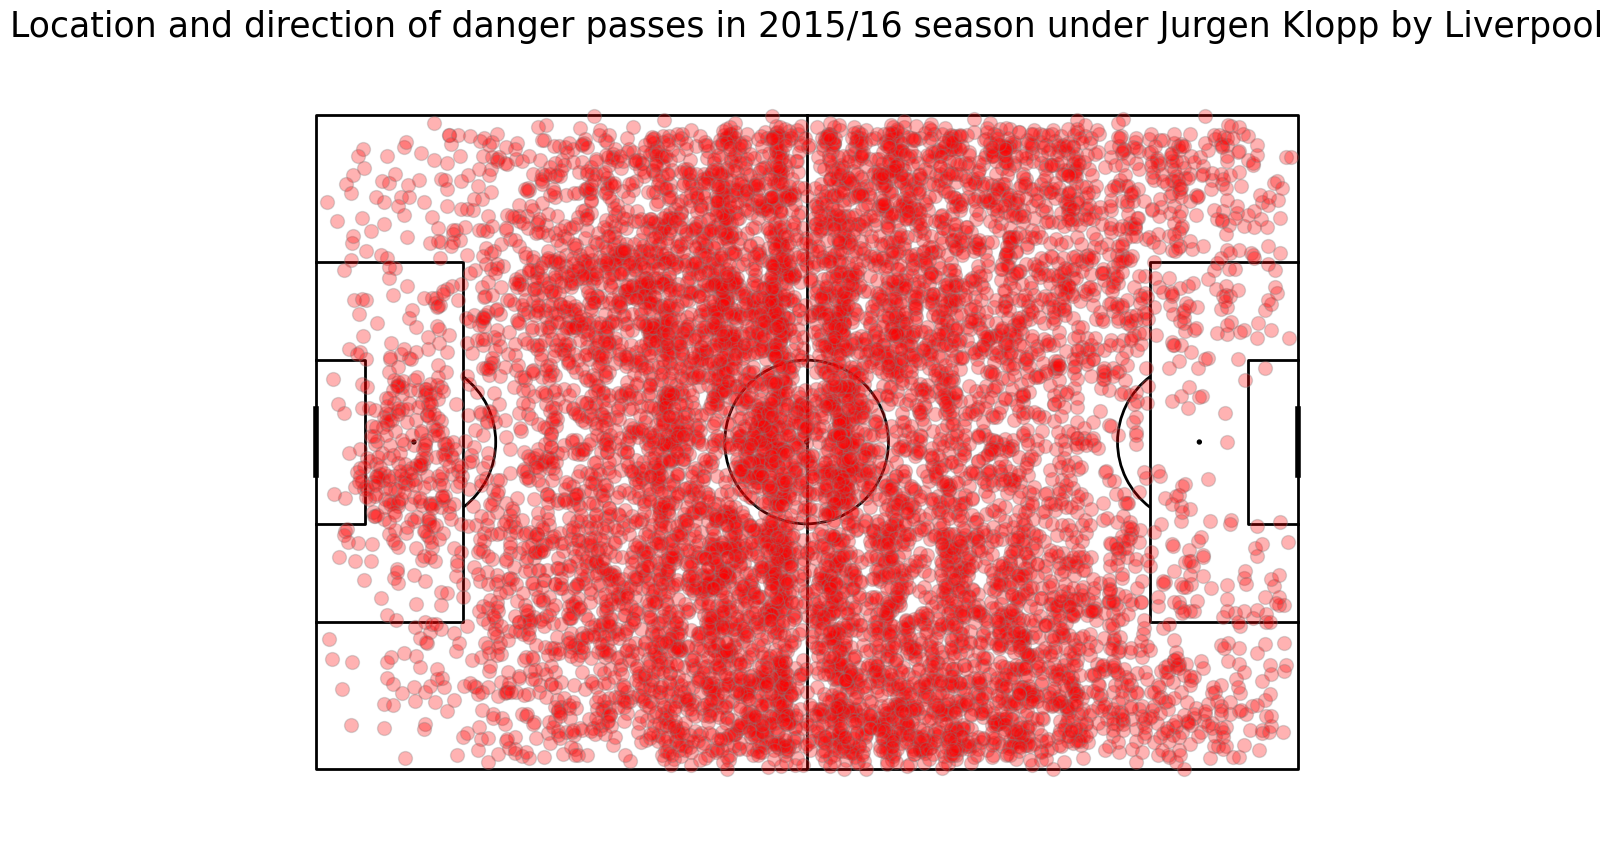

In [45]:
#first plot pitch
pitch = Pitch (line_color = 'black')
fig, ax = pitch.grid(grid_height = 0.8, title_height = 0.05, axis = False, 
                    endnote_height = 0.05, title_space = 0, endnote_space=  0)
#scatter location on the pitch plotted above
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color = 'red', edgecolors = 'grey', linewidth = 1, alpha = 0.3, ax = ax["pitch"])
#direction to those pass locations
#pitch.arrows( danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = 'red', ax = ax["pitch"])

#add title
fig.suptitle ('Location and direction of danger passes in 2015/16 season under Jurgen Klopp by '  + team, fontsize =25)
plt.show()

## making a heatmap out of that

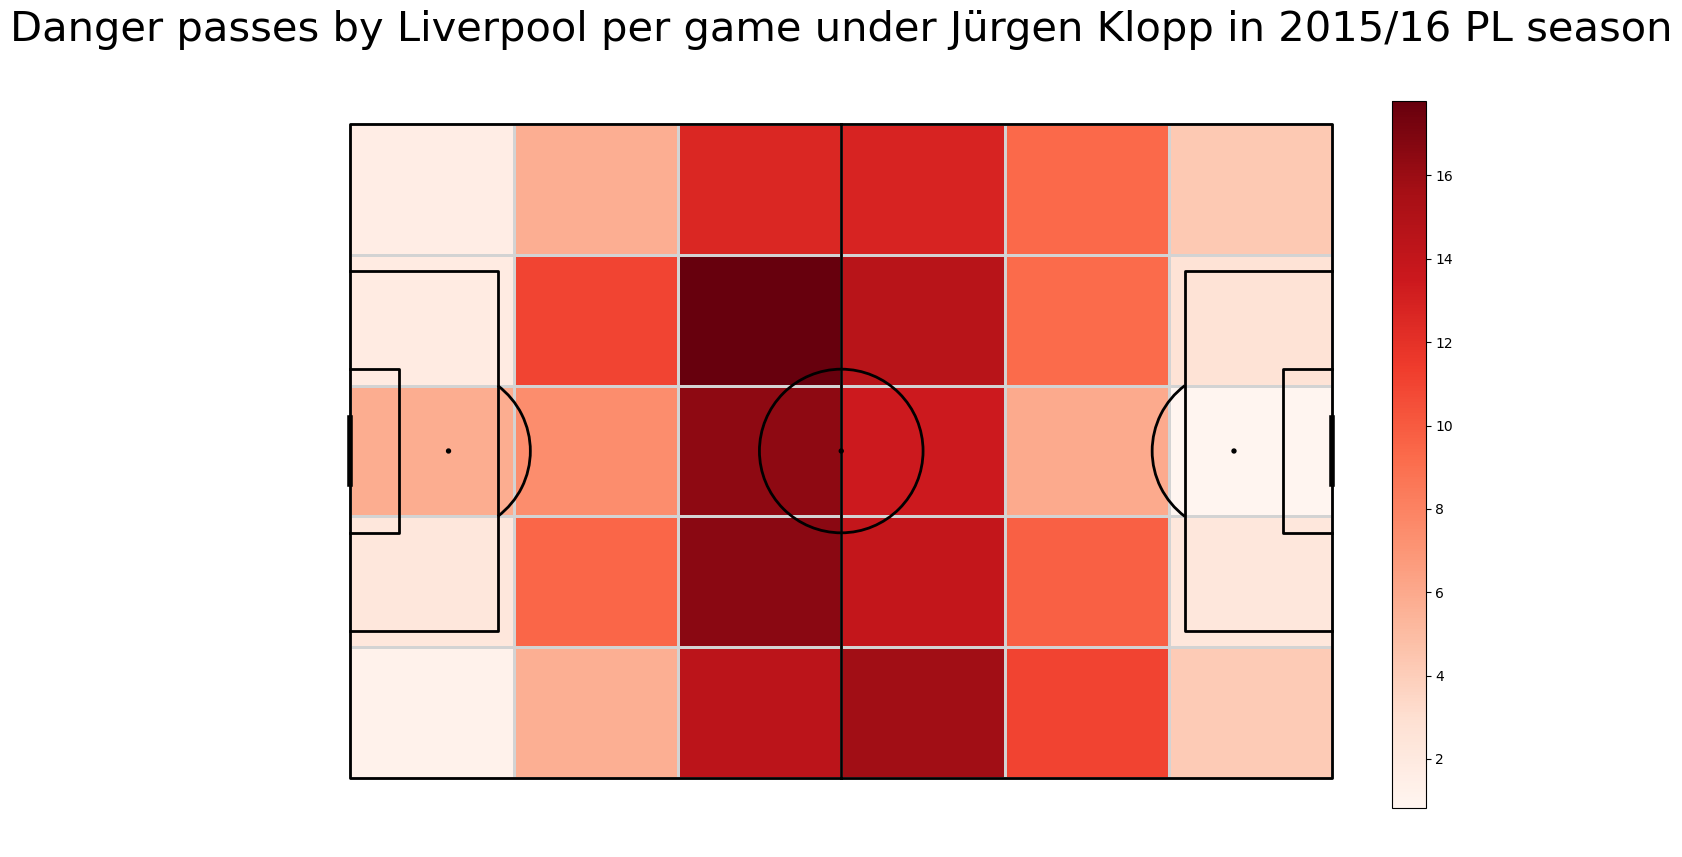

In [46]:
#plot vertical pitch
pitch = Pitch (line_zorder = 2, line_color = 'black')
fig, ax = pitch.grid (grid_height = 0.8, title_height = 0.06, axis = False, endnote_height = 0.04, title_space = 0,
                     endnote_space = 0)
#get 2d histogram plot
bin_stat = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic = 'count', bins = (6,5), normalize = False)
#normalise by number of games
bin_stat["statistic"] = bin_stat["statistic"]/no_games
#make heatmap
pcm = pitch.heatmap(bin_stat, cmap = 'Reds', edgecolor = 'lightgrey', ax = ax['pitch'])

#legend to the plot
ax_cbar = fig.add_axes ((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax = ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game under Jürgen Klopp in 2015/16 PL season", fontsize = 30)
plt.show()

## Who the most involved players were in making danger passes

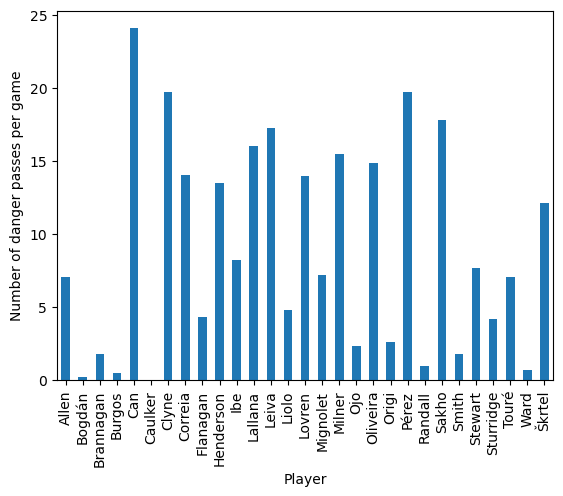

In [47]:
#keep only surnames for better visualisation
danger_passes ["player_name"] =  danger_passes ["player_name"]. apply (lambda x: str(x). split()[-1])
#count passes by players and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games
#make histogram
ax = pass_count.plot.bar(pass_count)
#title and other aesthetics
ax.set_xlabel("Player")
ax.set_ylabel("Number of danger passes per game")
plt.show()

## filtering the danger passes for shots with xG >0.7

In [48]:
danger_passes = pd.DataFrame()  #empty dataframe
for idx in matchids:
        df = parser.event(idx)[0]  #open event data
        for period in [1,2]:
            #keep only accurate LFC passes that were not set-pieces
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            #keep necessary columns
            passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
            #keep only shots by LFC
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            #keep only necessary columns
            shots = df.loc[mask_shot, ["minute", "second", "shot_statsbomb_xg"]]
            #filtering xG > 0.7
            high_xg_shots = shots [shots['shot_statsbomb_xg']>0.7]
            #time to seconds
            shot_times = high_xg_shots ['minute'] * 60 + high_xg_shots['second']
            shot_window = 15 #since passes 15 seconds before shots are taken for danger
            #find starts of the shot windows
            shot_start  = shot_times - shot_window
            #to avoid negative shot starts
            shot_start = shot_start.apply (lambda i: i if i<0 else (period - 1)*45)
            #convert to seconds
            pass_times = passes ['minute'] *60 +passes ['second']
            #check if any pass is in any of the windows for this half
            pass_to_shot = pass_times.apply (lambda x : True in ((shot_start < x) & (x <shot_times)).unique())
            
            #keep only danger passes as aimed
            danger_passes_p = passes.loc [pass_to_shot]
            #concatenate dataframe with a previous one to keep danger passes from the whole season
            danger_passes = pd.concat([danger_passes, danger_passes_p], ignore_index = True)


            

In [49]:
print(danger_passes)

         x     y  end_x  end_y  minute  second  \
0     59.5  39.6   50.9   46.3      45       1   
1     50.3  46.0   43.1   39.9      45       3   
2     41.8  43.4   33.6   53.8      45       6   
3     33.6  50.5   33.4   20.2      45       9   
4     40.2  20.8   39.4   27.8      45      13   
..     ...   ...    ...    ...     ...     ...   
815   64.1   7.2   57.8   19.7      68      41   
816   57.8  19.7   57.8   28.3      68      43   
817   60.1  35.7   50.3   47.5      68      46   
818   50.3  47.5   48.9   28.3      68      49   
819  112.7  29.8  109.8   37.7      69       0   

                             player_name  
0    Roberto Firmino Barbosa de Oliveira  
1                     Adam David Lallana  
2                               Emre Can  
3                           Dejan Lovren  
4                       Kolo Habib Touré  
..                                   ...  
815                 Alberto Moreno Pérez  
816               Jordan Brian Henderson  
817         

## plotting of danger passes on pitch  (xg> 0.7)

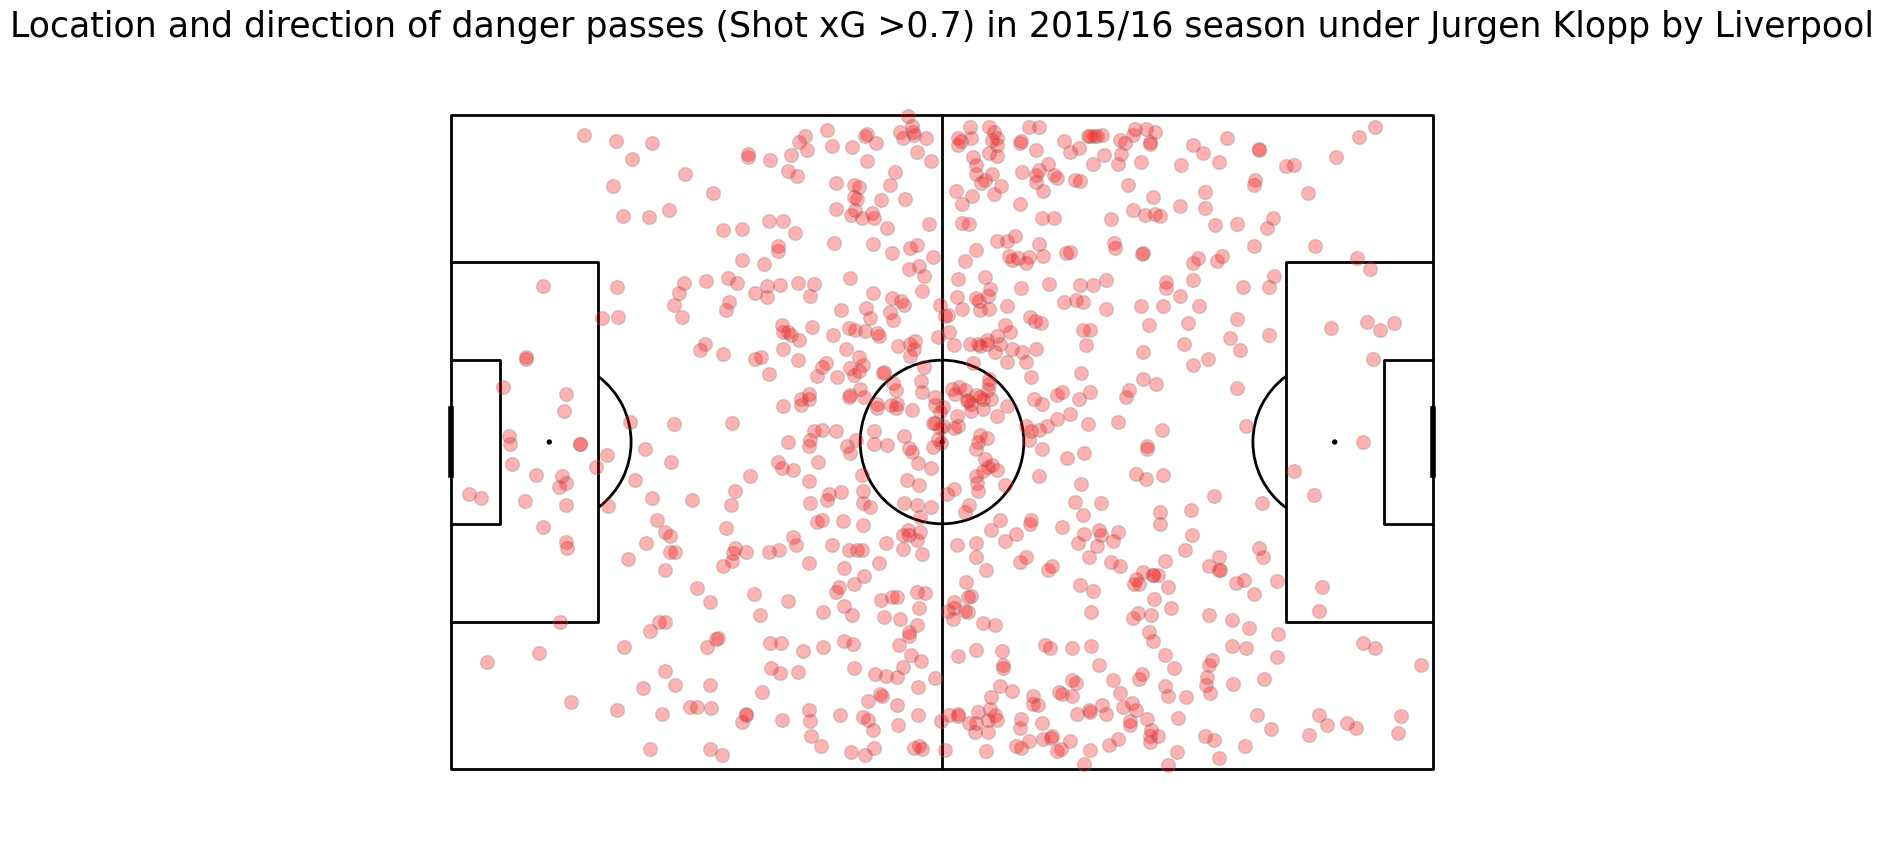

In [50]:
#first plot pitch
pitch = Pitch (line_color = 'black')
fig, ax = pitch.grid(grid_height = 0.8, title_height = 0.05, axis = False, 
                    endnote_height = 0.05, title_space = 0, endnote_space=  0)
#scatter location on the pitch plotted above
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color = 'red', edgecolors = 'grey', linewidth = 1, alpha = 0.3, ax = ax["pitch"])
#direction to those pass locations
#pitch.arrows( danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = 'red', ax = ax["pitch"])

#add title
fig.suptitle ('Location and direction of danger passes (Shot xG >0.7) in 2015/16 season under Jurgen Klopp by '  + team, fontsize =25)
plt.show()

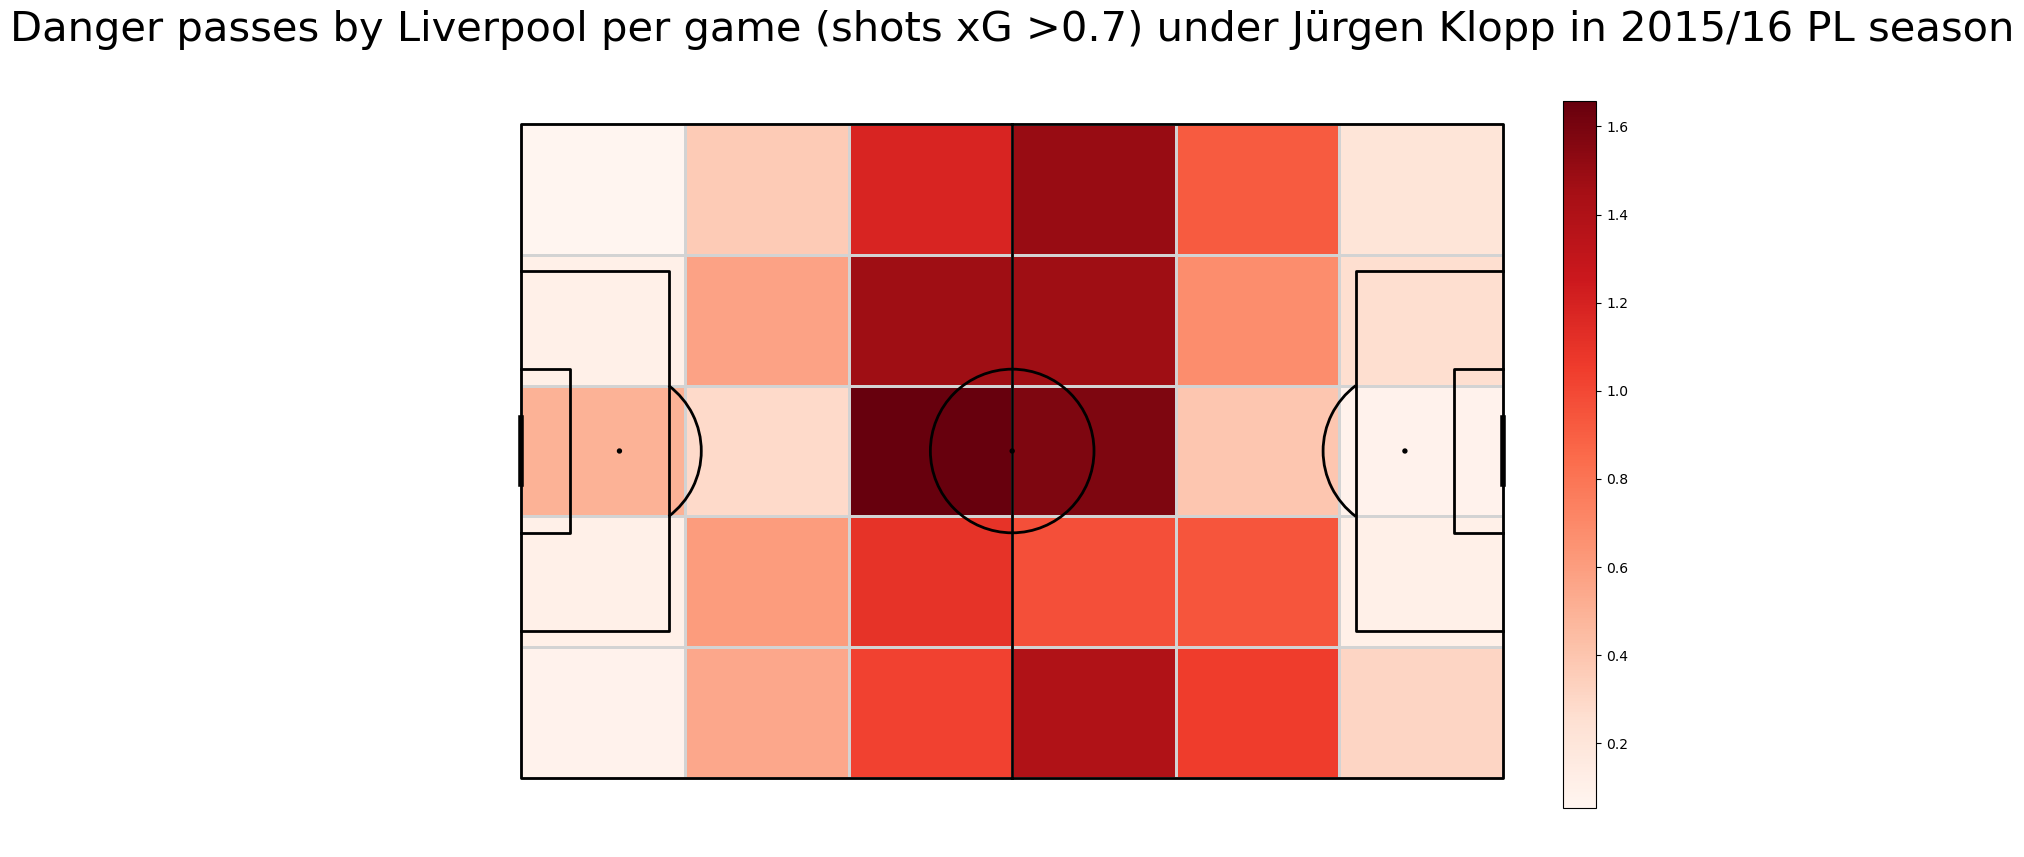

In [51]:
#plot vertical pitch
pitch = Pitch (line_zorder = 2, line_color = 'black')
fig, ax = pitch.grid (grid_height = 0.8, title_height = 0.06, axis = False, endnote_height = 0.04, title_space = 0,
                     endnote_space = 0)
#get 2d histogram plot
bin_stat = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic = 'count', bins = (6,5), normalize = False)
#normalise by number of games
bin_stat["statistic"] = bin_stat["statistic"]/no_games
#make heatmap
pcm = pitch.heatmap(bin_stat, cmap = 'Reds', edgecolor = 'lightgrey', ax = ax['pitch'])

#legend to the plot
ax_cbar = fig.add_axes ((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax = ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game (shots xG >0.7) under Jürgen Klopp in 2015/16 PL season", fontsize = 30)
plt.show()

# Who made them?

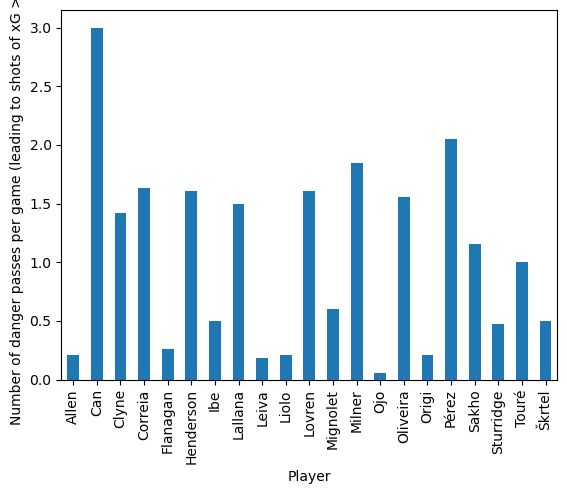

In [52]:
#keep only surnames for better visualisation
danger_passes ["player_name"] =  danger_passes ["player_name"]. apply (lambda x: str(x). split()[-1])
#count passes by players and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games
#make histogram
ax = pass_count.plot.bar(pass_count)
#title and other aesthetics
ax.set_xlabel("Player")
ax.set_ylabel("Number of danger passes per game (leading to shots of xG > 0.7)")
plt.show()

## Danger passes leading to xG >0.7 shots by Firmino

In [58]:
danger_passes

,x,y,end_x,end_y,minute,second,player_name
0,59.5,39.6,50.9,46.3,45,1,Oliveira
1,50.3,46.0,43.1,39.9,45,3,Lallana
2,41.8,43.4,33.6,53.8,45,6,Can
3,33.6,50.5,33.4,20.2,45,9,Lovren
4,40.2,20.8,39.4,27.8,45,13,Touré
...,...,...,...,...,...,...,...
815,64.1,7.2,57.8,19.7,68,41,Pérez
816,57.8,19.7,57.8,28.3,68,43,Henderson
817,60.1,35.7,50.3,47.5,68,46,Can
818,50.3,47.5,48.9,28.3,68,49,Touré


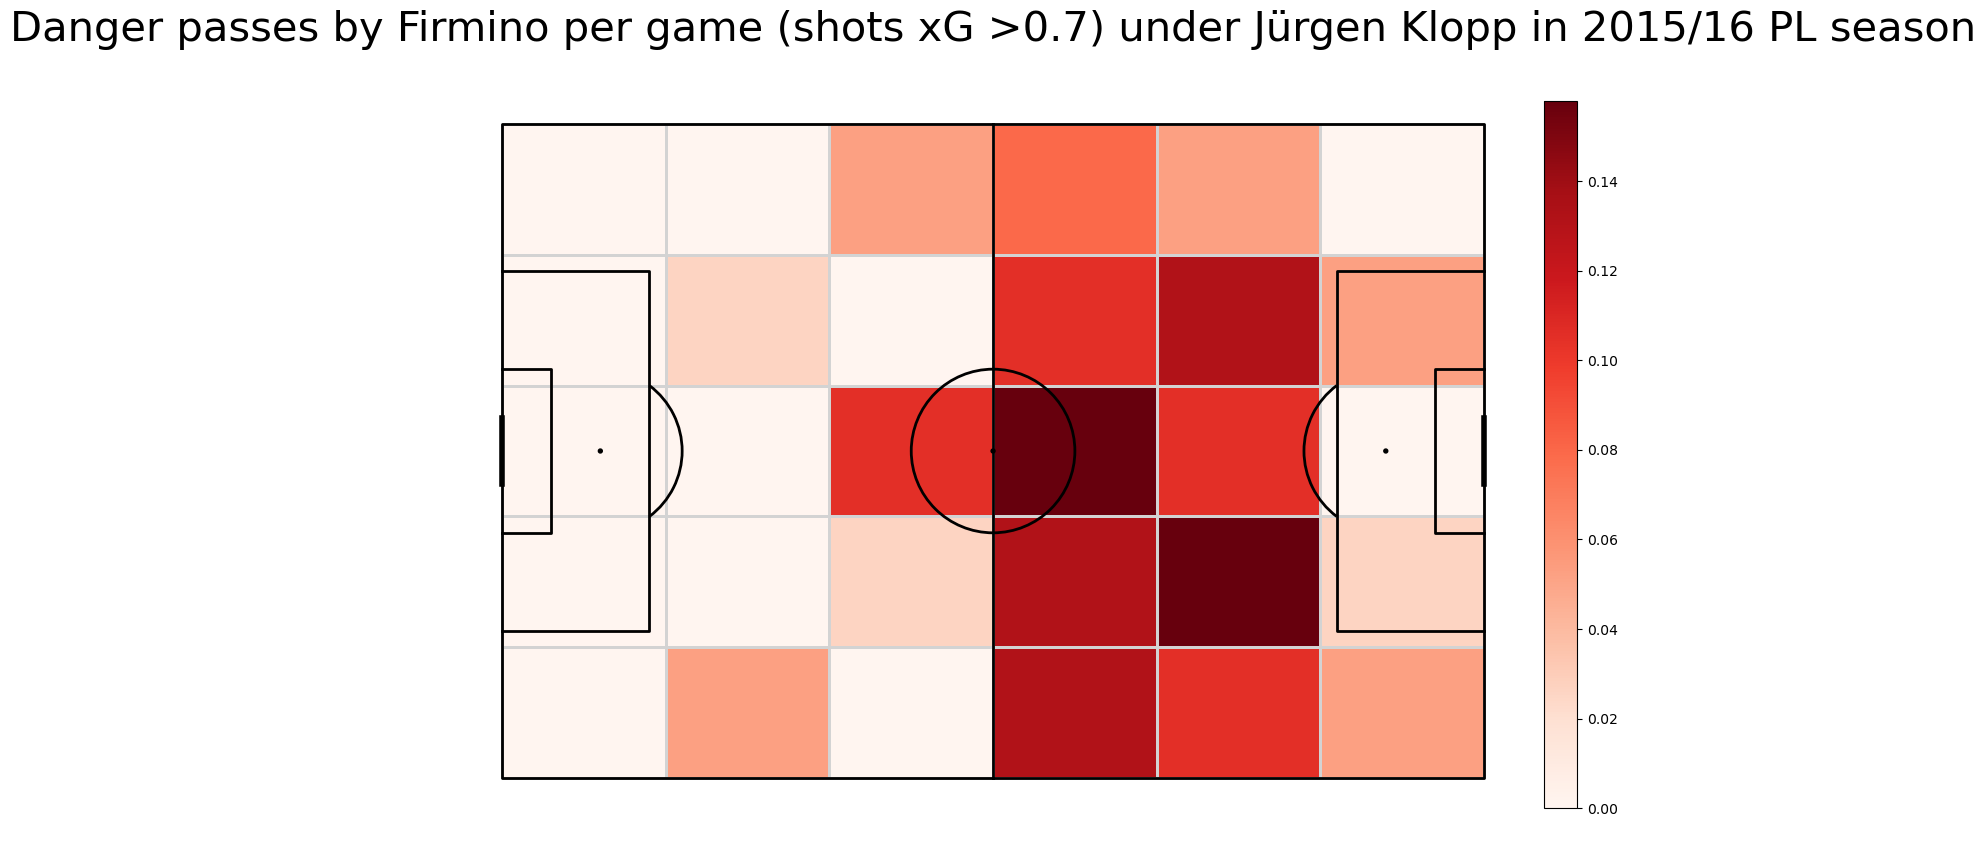

In [63]:
# Filter passes made only by Coutinho
firmino_passes = danger_passes[danger_passes['player_name'] == 'Oliveira']

# Plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.8, title_height=0.06, axis=False, endnote_height=0.04, title_space=0,
                     endnote_space=0)

# Get 2D histogram plot for Firmino's danger passes
bin_stat = pitch.bin_statistic(firmino_passes.x, firmino_passes.y, statistic='count', bins=(6, 5), normalize=False)

# Normalize by number of games
bin_stat["statistic"] = bin_stat["statistic"] / no_games

# Make heatmap
pcm = pitch.heatmap(bin_stat, cmap='Reds', edgecolor='lightgrey', ax=ax['pitch'])

# Add legend to the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by Firmino per game (shots xG >0.7) under Jürgen Klopp in 2015/16 PL season', fontsize=30)
plt.show()


## danger passes leading to shots (xG >0.7) by Coutinho

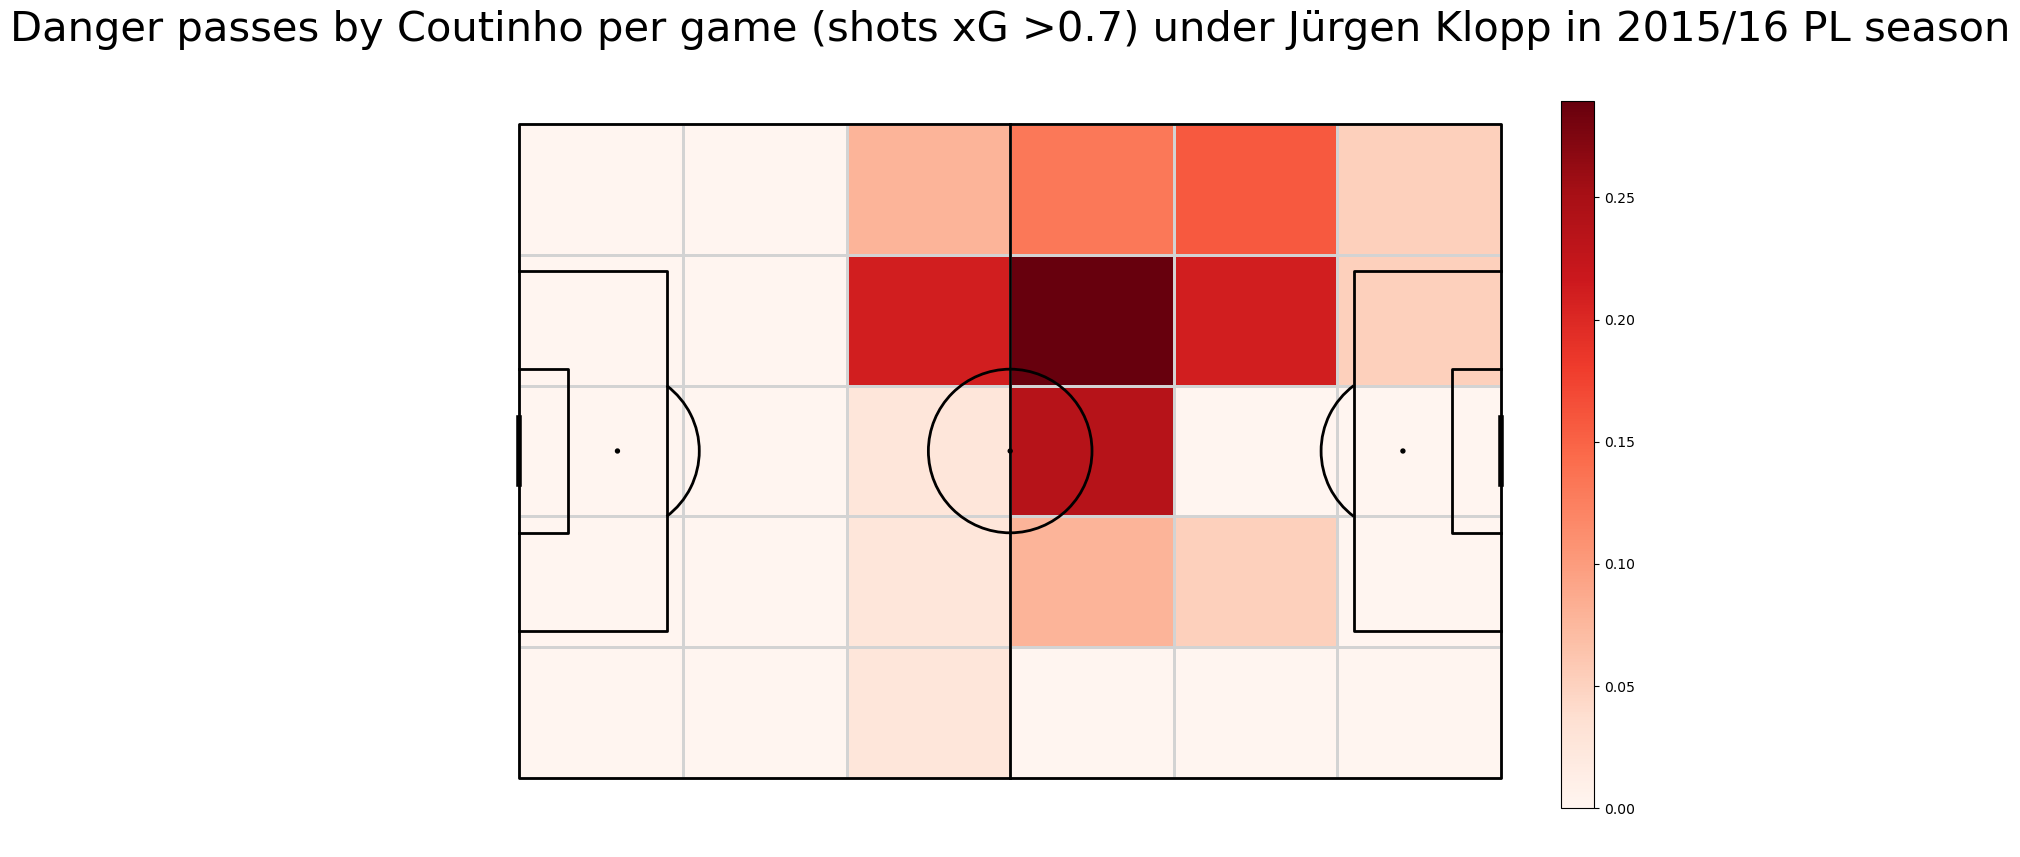

In [65]:
# Filter passes made only by Coutinho
coutinho_passes = danger_passes[danger_passes['player_name'] == 'Correia']

# Plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.8, title_height=0.06, axis=False, endnote_height=0.04, title_space=0,
                     endnote_space=0)

# Get 2D histogram plot for Coutinho's danger passes
bin_stat = pitch.bin_statistic(coutinho_passes.x, coutinho_passes.y, statistic='count', bins=(6, 5), normalize=False)

# Normalize by number of games
bin_stat["statistic"] = bin_stat["statistic"] / no_games

# Make heatmap
pcm = pitch.heatmap(bin_stat, cmap='Reds', edgecolor='lightgrey', ax=ax['pitch'])

# Add legend to the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by Coutinho per game (shots xG >0.7) under Jürgen Klopp in 2015/16 PL season', fontsize=30)
plt.show()
